<a href="https://colab.research.google.com/github/saarangmahun/comp215/blob/main/labs/lab08_GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Saarang Mahun
#### Date: March 13 2025

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [ ]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [51]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [52]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [62]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

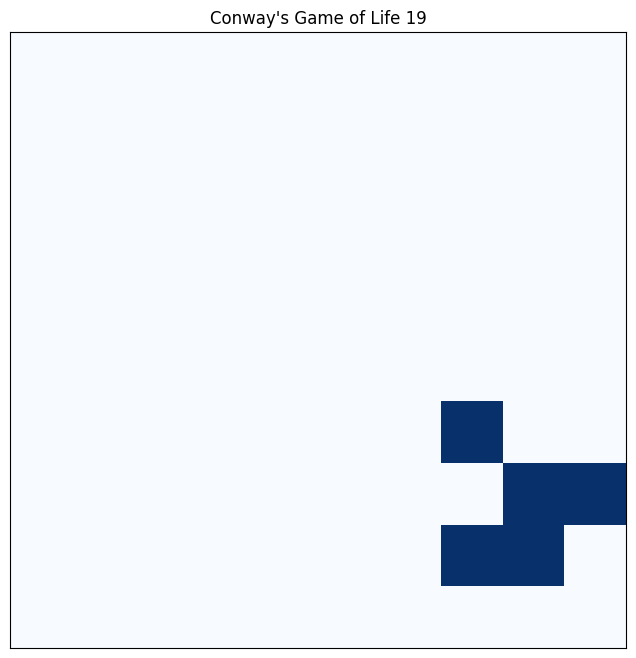

In [63]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

In [64]:
import math

# A 3x3 grid has 9 cells, each can be 0 or 1.
num_states = 2**9  # 2^9 = 512 unique states

# Each rule maps every one of these 512 states to 0 or 1.
num_rules = 2**(num_states)  # should be 2^(512) unique rules

print("Unique states in a 3x3 neighborhood:", num_states)
print("Unique rules:", num_rules)
print("Log10(Unique rules):", math.log10(num_rules))
print("Estimated atoms in the observable universe: ~1e80")

# Explanation:
# There are 512 unique neighborhood states.
# This gives 2^(512) unique rules,
# which is vastly more than ~10^(80) atoms in the universe.

Unique states in a 3x3 neighborhood: 512
Unique rules: 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096
Log10(Unique rules): 154.12735777995837
Estimated atoms in the observable universe: ~1e80


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1.
- Yes, but the number of possible rules is huge, so we’d need to sample or limit the search.
2.
- There are 512 possible 3×3 patterns.
- Pick a fixed order for these patterns.
- For each rule, list the output (0 or 1) for every pattern.
- Join these outputs into one long binary number and convert it to a decimal.
3.
- List all 3×3 patterns in the same fixed order.
- For each pattern, record if GoL makes the center cell live (1) or dead (0).
- Combine these into a binary string and convert it to a decimal number.
- That decimal is the rule number for GoL.

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

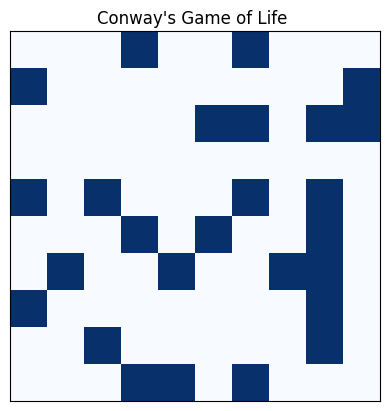

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

# A simple function to plot a 2D array.
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    axes = axes or plt.gca()
    axes.set_title(title)
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

# Basic Game of Life class.
class Life2D:
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])
    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        n_cols = n_cols or n_rows
        self.state = np.zeros((n_rows, n_cols), dtype=np.uint8)

    def step(self):
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

# Extended Life2D with a random start state.
class BetterLife2D(Life2D):
    def randomize_state(self, p):
        # Set each cell to 1 with probability p, else 0.
        self.state = (np.random.rand(*self.state.shape) < p).astype(np.uint8)

def random_life(n_rows, n_cols=None, p=0.5):
    n_cols = n_cols or n_rows
    life = BetterLife2D(n_rows, n_cols)
    life.randomize_state(p)
    return life

# Example usage:
if __name__ == '__main__':
    # Create a random Life game of size 10x10 with 30% chance of live cells.
    life_game = random_life(10, p=0.3)
    # Draw the initial state.
    life_game.draw()
    plt.show()


### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

p = 0.1, steps = 3
p = 0.2, steps = 100
p = 0.3, steps = 100
p = 0.4, steps = 100
p = 0.5, steps = 100
p = 0.6, steps = 100
p = 0.7, steps = 100
p = 0.8, steps = 3
p = 0.9, steps = 2


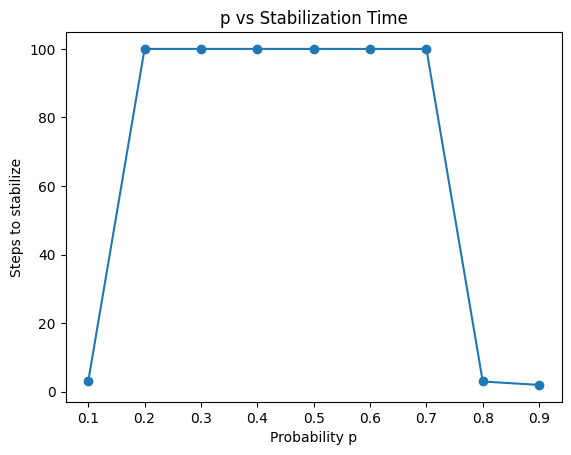

In [92]:
import numpy as np
import matplotlib.pyplot as plt

def run_until_stable(life_model, max_steps=100):
    # Run the game until the state stops changing.
    prev = life_model.state.copy()
    for step in range(1, max_steps+1):
        life_model.step()
        if np.array_equal(life_model.state, prev):
            return step
        prev = life_model.state.copy()
    return max_steps

# Try a range of p values.
ps = np.linspace(0.1, 0.9, 9)
stabilization_steps = []
for p in ps:
    life = random_life(20, p=p)  # Create a 20x20 board with live cell chance p
    steps = run_until_stable(life, max_steps=100)
    stabilization_steps.append(steps)
    print(f"p = {p:.1f}, steps = {steps}")

# Plot the results.
plt.plot(ps, stabilization_steps, 'o-')
plt.xlabel("Probability p")
plt.ylabel("Steps to stabilize")
plt.title("p vs Stabilization Time")
plt.show()


## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

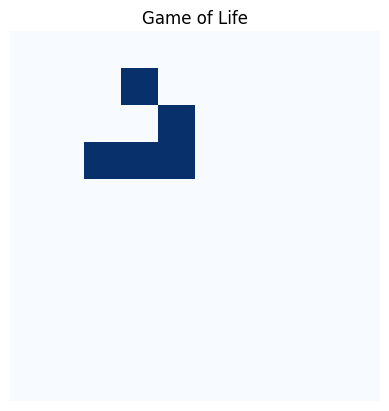

In [96]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """
#Anything I tried didn't work for this exercise, I couldn't find the reason for it.
import numpy as np
import matplotlib.pyplot as plt

def pattern_from_string(s):
    # Split the string into lines and convert each character to an int.
    lines = s.strip().splitlines()
    grid = [[int(ch) for ch in line.strip()] for line in lines if line.strip()]
    return np.array(grid, dtype=np.uint8)

class Life2D:
    def __init__(self, rows, cols=None):
        cols = cols or rows
        self.state = np.zeros((rows, cols), dtype=np.uint8)

    def draw(self):
        plt.imshow(self.state, cmap='Blues', interpolation='nearest', origin='upper')
        plt.title("Game of Life")
        plt.axis('off')
        plt.show()

class BetterLife2D(Life2D):
    def load_pattern(self, x, y, pattern):
        # Place the pattern into the state at position (x, y)
        rows, cols = pattern.shape
        self.state[x:x+rows, y:y+cols] = pattern

# Example usage:
if __name__ == '__main__':
    glider_pattern = """
    010
    001
    111
    """
    glider = pattern_from_string(glider_pattern)

    # Create a 10x10 board and insert the glider at row 1, column 2.
    life = BetterLife2D(10)
    life.load_pattern(1, 2, glider)
    life.draw()


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

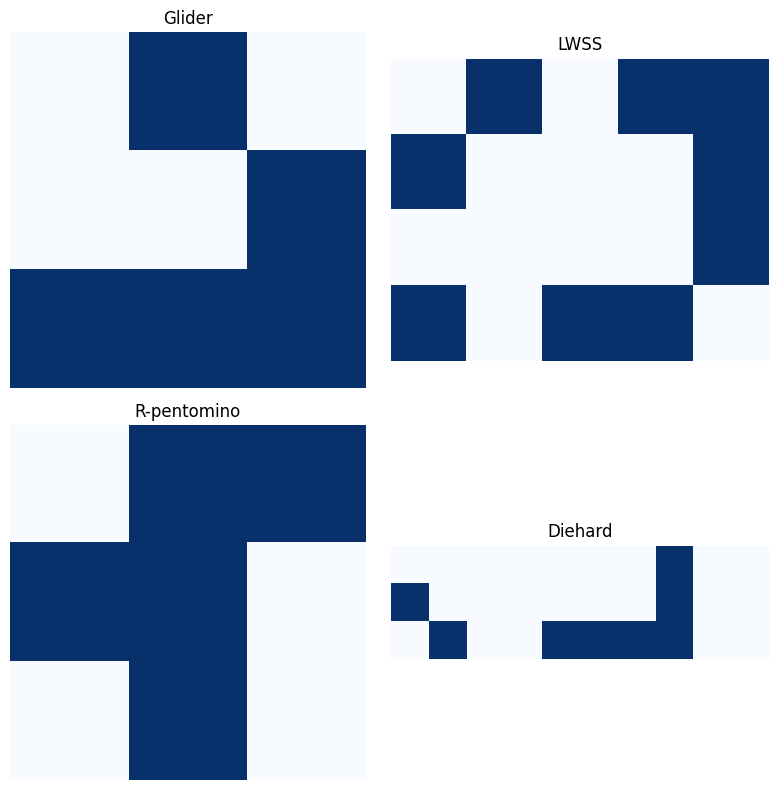

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def pattern_from_string(s):
    # Remove extra spaces and make a 2D array from the string.
    lines = s.strip().splitlines()
    return np.array([[int(ch) for ch in line.strip()] for line in lines if line.strip()], dtype=np.uint8)

# Define some cool Game of Life patterns as strings.
glider_pattern = """
010
001
111
"""

lwss_pattern = """
01011
10001
00001
10110
"""

r_pentomino_pattern = """
011
110
010
"""

diehard_pattern = """
0000000100
1000000100
0100111100
"""

# Convert patterns to 2D numpy arrays.
patterns = {
    "Glider": pattern_from_string(glider_pattern),
    "LWSS": pattern_from_string(lwss_pattern),
    "R-pentomino": pattern_from_string(r_pentomino_pattern),
    "Diehard": pattern_from_string(diehard_pattern)
}

# Plot the patterns.
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for ax, (name, pat) in zip(axs.flat, patterns.items()):
    ax.imshow(pat, cmap='Blues', interpolation='nearest', origin='upper')
    ax.set_title(name)
    ax.axis('off')

plt.tight_layout()
plt.show()

#Low-key the coolest lab I have witnessed so far :D I wonder what would happen if we integrated python libraries into this?


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

In [ ]:
# Ex. 3 code for your experiment here